In [1]:
# Cell 1: Import Library
import os
import cv2
import numpy as np
import pandas as pd
import random
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import platform

In [2]:
# Cell 2: Penetapan Seed untuk Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [3]:
# Cell 3: Konfigurasi Path dan Parameter
TRAIN_DIR = 'data/processed/processed_train'
VAL_DIR = 'data/processed/processed_val'
TEST_DIR = 'data/processed/processed_test'
TRAIN_CSV = 'data/train.csv'
VAL_CSV = 'data/val.csv'
TEST_CSV = 'data/test.csv'

BATCH_SIZE = 16
NUM_EPOCHS = 20
NUM_CLASSES = 5
LEARNING_RATE = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EARLY_STOPPING_PATIENCE = 5
NUM_WORKERS = 0 if platform.system() == "Windows" else 2

In [4]:
# Cell 4: Dataset Class
class FundusProcessedDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        label = int(self.data.iloc[idx, 1])
        img_path = os.path.join(self.img_dir, img_name)
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
# Cell 5: Transformasi dan DataLoader
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = FundusProcessedDataset(TRAIN_CSV, TRAIN_DIR, transform=train_transform)
val_dataset = FundusProcessedDataset(VAL_CSV, VAL_DIR, transform=val_test_transform)
test_dataset = FundusProcessedDataset(TEST_CSV, TEST_DIR, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [6]:
# Cell 6: Model, Loss, Optimizer, Scheduler
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

d:\1. SANDBOX\Project\Project 2025\dr-severity-efficientnetb0\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\1. SANDBOX\Project\Project 2025\dr-severity-efficientnetb0\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
d:\1. SANDBOX\Project\Project 2025\dr-severity-efficientnetb0\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [7]:
# Cell 7: Training Loop dengan Early Stopping & Visualisasi Progress
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_acc = 0
epochs_no_improve = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # --- VALIDASI ---
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Validation"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    scheduler.step(val_acc)

    # --- EARLY STOPPING & SIMPAN MODEL TERBAIK ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'efficientnetb0_best.pth')
        print("Model terbaik disimpan.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 1/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train Loss=1.2466, Train Acc=0.5317, Val Loss=1.0228, Val Acc=0.6000
Model terbaik disimpan.


Epoch 2/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2: Train Loss=1.0242, Train Acc=0.6167, Val Loss=0.9478, Val Acc=0.6067
Model terbaik disimpan.


Epoch 3/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.9583, Train Acc=0.6308, Val Loss=0.9674, Val Acc=0.6200
Model terbaik disimpan.


Epoch 4/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.8992, Train Acc=0.6308, Val Loss=0.8811, Val Acc=0.6400
Model terbaik disimpan.


Epoch 5/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 5/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.8468, Train Acc=0.6608, Val Loss=0.8979, Val Acc=0.6400


Epoch 6/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 6/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.8366, Train Acc=0.6783, Val Loss=0.8563, Val Acc=0.6600
Model terbaik disimpan.


Epoch 7/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 7/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.7896, Train Acc=0.6958, Val Loss=0.8702, Val Acc=0.7000
Model terbaik disimpan.


Epoch 8/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 8/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.7499, Train Acc=0.7067, Val Loss=0.8682, Val Acc=0.7267
Model terbaik disimpan.


Epoch 9/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 9/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.7134, Train Acc=0.7150, Val Loss=0.8857, Val Acc=0.7200


Epoch 10/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 10/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.6677, Train Acc=0.7358, Val Loss=0.9247, Val Acc=0.6733


Epoch 11/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 11/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.6537, Train Acc=0.7400, Val Loss=0.9250, Val Acc=0.6867


Epoch 12/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 12/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.5876, Train Acc=0.7708, Val Loss=0.9953, Val Acc=0.6733


Epoch 13/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 13/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.5458, Train Acc=0.7992, Val Loss=0.9356, Val Acc=0.7200
Early stopping at epoch 13


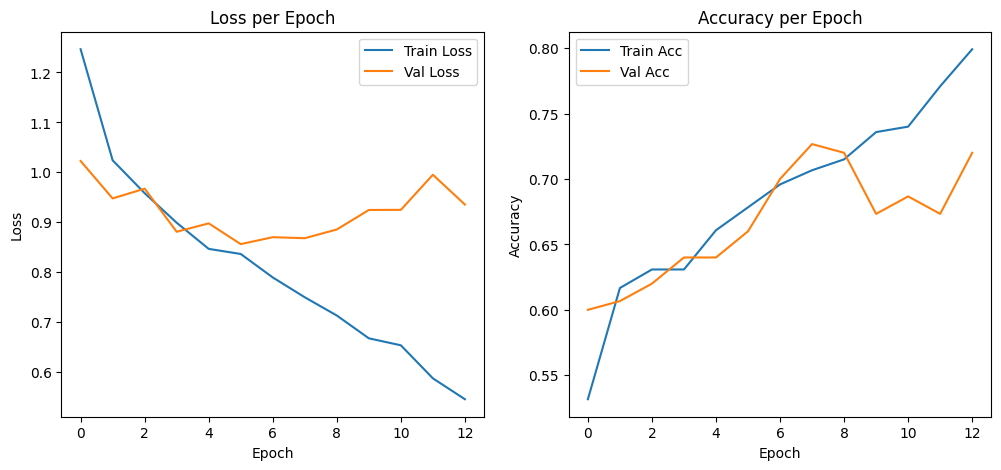

In [8]:
# Cell 8: Visualisasi Loss & Akurasi per Epoch
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.show()


Evaluasi pada data validasi:
              precision    recall  f1-score   support

  Severity 0       0.75      0.91      0.82        99
  Severity 1       0.50      0.23      0.32        26
  Severity 2       0.75      0.45      0.56        20
  Severity 3       0.60      1.00      0.75         3
  Severity 4       0.00      0.00      0.00         2

    accuracy                           0.72       150
   macro avg       0.52      0.52      0.49       150
weighted avg       0.69      0.72      0.69       150



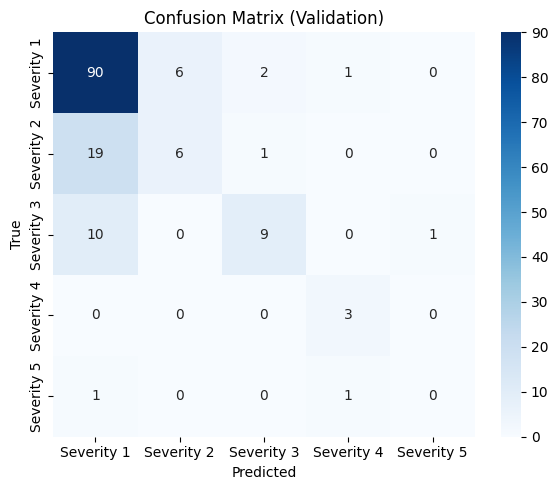

In [9]:
# Cell 9: Evaluasi pada Data Validasi
print("\nEvaluasi pada data validasi:")
print(classification_report(all_labels, all_preds, target_names=[f"Severity {i}" for i in range(5)]))
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Severity {i+1}" for i in range(NUM_CLASSES)],
            yticklabels=[f"Severity {i+1}" for i in range(NUM_CLASSES)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Validation)')
plt.tight_layout()
plt.show()

C:\Users\aryas\AppData\Local\Temp\ipykernel_14772\2722649198.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('efficientnetb0_best.pth'))

Testing:   0%|          | 0/10 [00:00<?, ?it/s]


Evaluasi pada data test:
              precision    recall  f1-score   support

  Severity 0       0.75      0.88      0.81        90
  Severity 1       0.35      0.26      0.30        23
  Severity 2       0.50      0.45      0.47        29
  Severity 3       0.00      0.00      0.00         5
  Severity 4       0.00      0.00      0.00         3

    accuracy                           0.65       150
   macro avg       0.32      0.32      0.32       150
weighted avg       0.60      0.65      0.62       150



d:\1. SANDBOX\Project\Project 2025\dr-severity-efficientnetb0\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\1. SANDBOX\Project\Project 2025\dr-severity-efficientnetb0\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\1. SANDBOX\Project\Project 2025\dr-severity-efficientnetb0\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

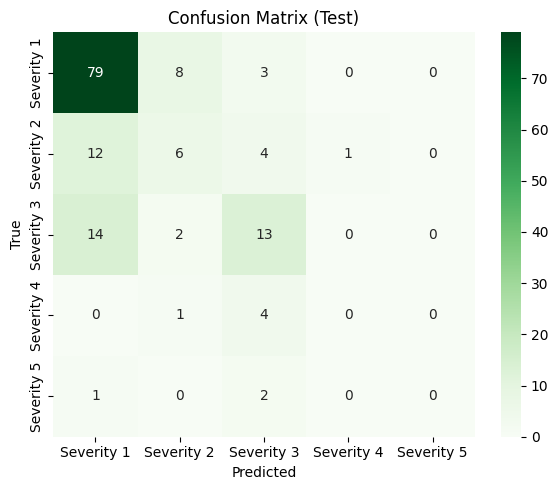

In [10]:
# Cell 10: Evaluasi pada Data Test
model.load_state_dict(torch.load('efficientnetb0_best.pth'))
model.eval()
test_labels = []
test_preds = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())

print("\nEvaluasi pada data test:")
print(classification_report(test_labels, test_preds, target_names=[f"Severity {i}" for i in range(5)]))
cm_test = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=[f"Severity {i+1}" for i in range(NUM_CLASSES)],
            yticklabels=[f"Severity {i+1}" for i in range(NUM_CLASSES)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test)')
plt.tight_layout()
plt.show()

In [11]:
# Gunakan jika ingin mematikan komputer otomatis setelah proses selesai
# # Cell 11: Shutdown Komputer
# import os
# print("Training selesai! Komputer akan dimatikan dalam 60 detik...")
# os.system("shutdown /s /t 60")